# Stream fit

### The stream is modelled with a segment of the orbit. The potential is kept fixed. The optimization is among the initial conditions of the stream progenitor.


In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from scipy.integrate import solve_ivp
from astropy.io import ascii
from scipy import optimize
from scipy import interpolate

## The orbit model
The orbit should be integrated backwards and forwards during a given time span.

In [2]:
# Mass and density profile (RAR)

exec(open("./model_def.py").read())     

# Rar model evaluation
ener_f = 56.0  # keV
param = np.array([ener_f, 3.77656e+01,6.63407e+01,1.1977e-05])
r_mw,mass_mw = model(param)
rho_mw = np.diff(mass_mw)/np.diff(r_mw)/(4.0*np.pi*r_mw[:-1]**2)  # M_sun/pc^3

# Interpolation avoiding NANs
k = np.argwhere(np.isnan(mass_mw))[0][0]
r_sh = r_mw[0:k]
mass_sh = mass_mw[0:k]
r_max_mw=r_sh[-1]

mass_spline = InterpolatedUnivariateSpline(r_sh,mass_sh,k=4)  # Allows easy computation of derivatives
def rho_spline(r) :
    deriv= mass_spline.derivative(1)
    return deriv(r)/(4.0*np.pi*r*r)


37.7656 66.3407 1.1977e-05


/home/mmestre/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
/home/mmestre/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


In [41]:
# Gravitational acceleration



exec(open("./accelerations.py").read()) 
exec(open("./accelerations_combine.py").read()) 



#------------------
# Gradient generated by MW's halo
def symp_grad_mw(t, w):
    x=w[0]
    y=w[1]
    z=w[2]
    px=w[3]
    py=w[4]
    pz=w[5]
    r=np.sqrt(x*x+y*y+z*z)
    #print('time=',t)
    return [px,py,pz, accel_mw(x,y,z)[0], accel_mw(x,y,z)[1], accel_mw(x,y,z)[2]]

print(accel_mw(1.,1.,1.)[0])
print( symp_grad_mw(1.0,np.array([1.,1.,1.,1.,1.,1.])) )

r_200= 209.41344788869304
a_nfw= 17.451120657391087
accel_efds= [-1984.88472091 -1984.88472091 -9002.67404088]
spline= [2807.05089205]
spline= 2807.050892052442
fun= 2807.0423185996196
-2249.159366403527
[1.0, 1.0, 1.0, -2249.159366403527, -2249.159366403527, -9266.9486863823]


In [33]:
# from Gala Package (to acknowledge)
""" Astropy coordinate class for the Sagittarius coordinate system """

# Third-party
import numpy as np

import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_transpose

__all__ = ["GD1Koposov10", "GD1"]



class GD1Koposov10(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the orbit
    of the GD1 stream, as described in
    Koposov et al. 2010 (see: `<http://arxiv.org/abs/0907.1085>`_).

    For more information about this class, see the Astropy documentation
    on coordinate frames in :mod:`~astropy.coordinates`.

    Parameters
    ----------
    representation : :class:`~astropy.coordinates.BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)

    phi1 : angle_like, optional, must be keyword
        The longitude-like angle corresponding to GD-1's orbit.
    phi2 : angle_like, optional, must be keyword
        The latitude-like angle corresponding to GD-1's orbit.
    distance : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    pm_phi1_cosphi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the longitude-like direction corresponding to
        the GD-1 stream's orbit.
    pm_phi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the latitude-like direction perpendicular to the
        GD-1 stream's orbit.
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    """
    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
    }

    _default_wrap_angle = 180*u.deg

    def __init__(self, *args, **kwargs):
        wrap = kwargs.pop('wrap_longitude', True)
        super().__init__(*args, **kwargs)
        if wrap and isinstance(self._data, (coord.UnitSphericalRepresentation,
                                            coord.SphericalRepresentation)):
            self._data.lon.wrap_angle = self._default_wrap_angle

    # TODO: remove this. This is a hack required as of astropy v3.1 in order
    # to have the longitude components wrap at the desired angle

    def represent_as(self, base, s='base', in_frame_units=False):
        r = super().represent_as(base, s=s, in_frame_units=in_frame_units)
        r.lon.wrap_angle = self._default_wrap_angle
        return r





# Rotation matrix as defined in the Appendix of Koposov et al. (2010)
R = np.array([[-0.4776303088, -0.1738432154, 0.8611897727],
              [0.510844589, -0.8524449229, 0.111245042],
              [0.7147776536, 0.4930681392, 0.4959603976]])


@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.ICRS,
                                 GD1Koposov10)
def icrs_to_gd1():
    """ Compute the transformation from Galactic spherical to
        heliocentric GD1 coordinates.
    """
    return R


@frame_transform_graph.transform(coord.StaticMatrixTransform, GD1Koposov10,
                                 coord.ICRS)
def gd1_to_icrs():
    """ Compute the transformation from heliocentric GD1 coordinates to
        spherical Galactic.
    """
    return matrix_transpose(icrs_to_gd1())


# TODO: remove this in next version
class GD1(GD1Koposov10):
    def __init__(self, *args, **kwargs):
        import warnings
        warnings.warn("This frame is deprecated. Use GD1Koposov10 instead.",
                      DeprecationWarning)
        super().__init__(*args, **kwargs)


trans = frame_transform_graph.get_transform(GD1Koposov10,
                                            coord.ICRS).transforms[0]
frame_transform_graph.add_transform(GD1, coord.ICRS, trans)
trans = frame_transform_graph.get_transform(coord.ICRS,
                                            GD1Koposov10).transforms[0]
frame_transform_graph.add_transform(coord.ICRS, GD1, trans)

w_0 =  [  -3.41   13.      9.58 -200.4  -162.6    13.9 ]


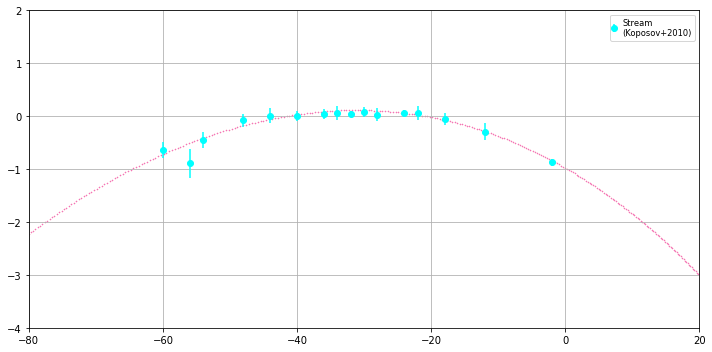

w_0 =  [  -3.41   13.      9.58 -200.4  -162.6    13.9 ]
chi^2 = 107.84079793948698
107.84079793948698


In [6]:
# Computation of the orbit model for Koposov+10 logarithmic potential and data.
# Optimization to find best fit orbit.

# This cell contains additional computations outside the main objective of this notebook.
# The orbit_model here defined works with cartesian coordinates both in the input and output.

exec(open("./stream_Koposov_data.py").read()) 

# Orbit model definition
#-------------------------------------
def orbit_model(w_0):
    print('w_0 = ',w_0)
    
    # ODE integration
    unit_t = 0.977792221680356   # Gyr
    time_span_s2 = 0.2/unit_t #
    t_0=0.0/unit_t    
    n_steps = 1000
    t_back = np.linspace(t_0,-time_span_s2, n_steps+1)
    t_forw = np.linspace(t_0,time_span_s2, n_steps+1)       
    sol_back = solve_ivp(symp_grad_mw, [t_0,-time_span_s2], w_0, t_eval=t_back,method='DOP853',rtol=5.0e-14,atol=0.5e-14)
    sol_forw = solve_ivp(symp_grad_mw, [t_0,time_span_s2], w_0, t_eval=t_forw,method='DOP853',rtol=5.0e-14,atol=0.5e-14)
    
    t = np.concatenate([sol_back.t,sol_forw.t])
    y = np.concatenate([sol_back.y, sol_forw.y],axis=1)
    #print(np.shape(y))
    y = np.delete(y,0,axis=1) #Remove duplicated column
    #print(np.shape(y))
    
    #Transformation to GD-1 frame of coordinates (\phi_1, \phi_2)
    galcen_distance = 8.5*u.kpc
    v_sun = coord.CartesianDifferential([11.1, 220.0+12.24, 7.25]*u.km/u.s)
    z_sun=0.0*u.kpc
    galac_coord=coord.Galactocentric(x=y[0]*u.kpc,y=y[1]*u.kpc,z=y[2]*u.kpc,
                                     v_x=y[3]*u.km/u.s,v_y=y[4]*u.km/u.s,v_z=y[5]*u.km/u.s,
                           galcen_distance=galcen_distance,galcen_v_sun=v_sun,z_sun=z_sun) 
    gd1_coord = galac_coord.transform_to(GD1Koposov10)
    phi_1 = gd1_coord.phi1
    phi_2 = gd1_coord.phi2
    d_hel = gd1_coord.distance
    v_hel = gd1_coord.radial_velocity
    mu_phi_1 = gd1_coord.pm_phi1_cosphi2/np.cos(phi_2)
    mu_phi_2 = gd1_coord.pm_phi2
    
    return phi_1, phi_2, d_hel, v_hel, mu_phi_1, mu_phi_2  #the time "t" is not needed

# Test call:
#------------------
w_0=np.array([-3.41, 13.0, 9.58, -200.4, -162.6, 13.9])
#w_0=np.array([-1.716384450138328077e+00, 1.401126977875537705e+01, 9.227965941367614278e+00,-2.031152426286328421e+02, -1.368983530061972260e+02, 3.428826606652827280e+01])
phi_1,phi_2,d_hel,v_hel,mu_1,mu_2 = orbit_model(w_0) 
    
# Plots in the sky using the GD-1 frame
#------------------------------------------------------
fig=plt.figure(figsize=(10,5))

# sky position
plt.scatter(phi_1.wrap_at(180*u.deg),phi_2,s=0.1,marker='o', color='red')
plt.scatter(phi_1,phi_2,s=0.1,marker='o', color='violet')
plt.errorbar(kop_sky['phi1'], kop_sky['phi2'], yerr=kop_sky['err'], fmt='o', color='cyan', label='Stream\n(Koposov+2010)')
plt.ylim(-4,2)

# heliocentric radial velocity 
#plt.scatter(phi_1.wrap_at(180*u.deg),v_hel,s=0.1,marker='o', color='red')
#plt.errorbar(kop_rv['phi1'], kop_rv['vr'], yerr=kop_rv['err'], fmt='o', color='cyan', label='Stream\n(Koposov+2010)')
#plt.ylim(-400,200)

# heliocentric distance
#plt.scatter(phi_1,d_hel,s=0.1,marker='o', color='violet')
#plt.errorbar(kop_dist['phi1'], kop_dist['dist'], yerr=kop_dist['err'], fmt='o', color='cyan', label='Stream\n(Koposov+2010)')
#plt.ylim(5,15)

# proper motion along phi_1 and phi_2
#plt.scatter(phi_1,mu_1,s=0.1,marker='o', color='violet')
#plt.scatter(phi_1,mu_2,s=0.1,marker='o', color='red')
#plt.errorbar(kop_pm['phi1'], kop_pm['mu_phi1'], yerr=kop_pm['err'], fmt='o', color='blue', label='Stream\n(Koposov+2010)')
#plt.errorbar(kop_pm['phi1'], kop_pm['mu_phi2'], yerr=kop_pm['err'], fmt='o', color='cyan', label='Stream\n(Koposov+2010)')

plt.xlim(-80,20)
plt.grid()
plt.legend(fontsize='small', handlelength=0.3)

plt.tight_layout()
plt.show()
fig.savefig("plots/pm_fit_my_w0.png")

# Optimization
#-------------------------------------

def chi2(w_0):
    phi_1,phi_2,d_hel,v_hel,mu_1,mu_2 = orbit_model(w_0) 
    phi_2_spl = interp1d(phi_1,phi_2,kind='cubic')
    d_hel_spl = interp1d(phi_1,d_hel,kind='cubic')
    v_hel_spl = interp1d(phi_1,v_hel,kind='cubic')
    mu_1_spl  = interp1d(phi_1,mu_1,kind='cubic')
    mu_2_spl  = interp1d(phi_1,mu_2,kind='cubic')

    sum=np.zeros(5)

    y_mod = phi_2_spl(kop_sky['phi1'])
    y_dat = kop_sky['phi2']
    sigma2 = kop_sky['err']**2
    sum[0] = np.sum( (y_dat-y_mod)**2 / sigma2 )

    y_mod = v_hel_spl(kop_rv['phi1'])
    y_dat = kop_rv['vr']
    sigma2 = kop_rv['err']**2
    sum[1] = np.sum( (y_dat-y_mod)**2 / sigma2 )
    
    y_mod = d_hel_spl(kop_dist['phi1'])
    y_dat = kop_dist['dist']
    sigma2 = kop_dist['err']**2
    sum[2] = np.sum( (y_dat-y_mod)**2 / sigma2 )
    
    y_mod = mu_1_spl(kop_pm['phi1'])
    y_dat = kop_pm['mu_phi1']
    sigma2 = kop_pm['err']**2
    sum[3] = np.sum( (y_dat-y_mod)**2 / sigma2 )
    
    y_mod = mu_2_spl(kop_pm['phi1'])
    y_dat = kop_pm['mu_phi2']
    sigma2 = kop_pm['err']**2
    sum[4] = np.sum( (y_dat-y_mod)**2 / sigma2 )
    
    print('chi^2 =',np.sum(sum))
    return np.sum(sum)

print(chi2(w_0))


dx = 5.0
dv = 30.0
w_0=np.array([-3.41, 13.0, 9.58, -200.4, -162.6, 13.9]) 
bounds=((w_0[0]-dx,w_0[0]+dx), (w_0[1]-dx,w_0[1]+dx), (w_0[2]-dx,w_0[2]+dx),
        (w_0[3]-dv,w_0[3]+dv), (w_0[4]-dv,w_0[4]+dv), (w_0[5]-dv,w_0[5]+dv))

#opt=optimize.differential_evolution(chi2, bounds,strategy='best1bin',maxiter=20,popsize=20,tol=5.0e-8,atol=0.5e-8,disp=True,polish=True,workers=-1)

#param_fitted = opt.x

#np.savetxt('param_fitted.txt', param_fitted, delimiter=',')  

param=  157.6 43.717 8.25 -4.71963667724046 -11.0 -90.0
[-29d40m52.7573s -29d24m43.9916s -29d08m38.0494s ... 133d49m38.5554s
 133d44m17.4296s 133d38m56.5044s]
[ 8.265307    8.28072871  8.29626406 ... 25.17233387 25.17682425
 25.18126281] kpc


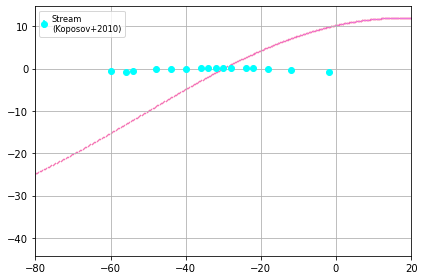

param= param= param=  param= 165.39426703550254  169.668137921640344.49923858348545 163.56100082526044   8.713138457382401 40.3292539892170839.35343140134768172.14146420126008   46.50525713672433  -4.3141367124618847.482484348829873 -4.29993578885411058.9990456795051377.9556606380691   -11.220682568633734-4.682578674305605  -11.35873785600204 -98.81320396484897
 -11.517231249410123 -83.2426183463577-88.94208962762981

-4.979344766313032 -10.435353637682166 -87.03758736897267
chi^2 = 685710.6076179249
param=  166.16573250570133 41.442427888048876 8.752733391931898 -4.261143348405825 -11.691214005318189 -94.88852781181119
chi^2 = 327358.4462480349
param=  170.44885074842313 47.52551577482285 8.15521030941847 -4.8364930114402815 -9.94246841602865 -89.74687686041324
chi^2 = 247317.56084881662
param=  149.8210527570318 43.18128195428877 8.6781035975857 -4.660028547245301 -10.50446717622649 -85.16391461340058
chi^2 = 192420.51136452754
param=  172.96792051709687 43.4922314260526 8.0982498542

param=  148.94031894085455 43.890586020150145 7.811059378997146 -4.529966365539369 -11.772827492765122 -98.98015287242264
chi^2 = 482721.94396041345
param=  160.3417879243179 39.94161392492859 9.053689000673293 -4.813204139706011 -10.210969535886187 -94.37868747971532
chi^2 = 69813.08136207156
param=  163.71568099283144 44.136253051024866 7.746756431069853 -4.567559145674751 -11.909107317297847 -94.25905971346751
chi^2 = 103275.10183121376
param=  166.88503066044726 44.22621508644145 8.461894363700626 -4.887350747165086 -11.129300857988387 -88.56138322238357
chi^2 = 82893.33824150753
param=  171.81976333374254 39.51793582444613 9.007468134277318 -4.634332496051831 -10.169612320217599 -91.73227026965294
chi^2 = 65638.42290153417
param=  159.94363211094873 42.16367867562405 8.30761094419865 -4.6736221477809945 -11.028040207540391 -84.80193560603121
chi^2 = 200451.59511872113
param=  159.3538494006084 47.68512275801197 8.583093846463846 -4.350462516524795 -10.770508987754068 -89.555859351

param=  151.57403203423098 42.333719850556 8.419762348046936 -4.647361315905211 -11.2460704566483 -96.29781499768761
chi^2 = 59953.89795338154
param=  143.52312844354077 48.0036892999395 7.456626005630243 -4.699710441623165 -12.009983604972644 -84.03454346764644
chi^2 = 391822.12764711387
param=  145.4732671293997 44.26534058203528 7.7895928270620285 -4.469276145794674 -10.118571284332647 -87.80010826571359
chi^2 = 48781.00807509726
param=  142.46386301432773 42.81045360473781 8.192815267622652 -4.859716700466708 -10.178845801591077 -83.3316307537397
chi^2 = 198302.6670313311
param=  142.998557223627 44.443567834669516 8.81931875130866 -5.177505602501039 -11.107561355706613 -93.46223250987809
chi^2 = 88995.34939742785
param=  156.4400066221626 46.3306049823782 8.36526479431878 -4.398702215316696 -10.61613852446151 -81.90158454907049
chi^2 = 79664.74577020037
param=  153.39374277343617 43.6274090371137 8.202845529043298 -4.611048457604527 -11.40791813283048 -87.63441169623844
chi^2 = 13

param=  148.61334906203152 40.11560979843314 7.542045704029894 -4.779957077861651 -10.901807174807908 -91.2549005840742
chi^2 = 114028.70390401139
param=  164.37624920441579 41.45163872870965 8.827907523735796 -4.723171663658404 -11.597521893837374 -97.9762408839642
chi^2 = 293219.3272573026
param=  152.3330419305488 43.43699706020343 7.5830265099804945 -4.942181723503039 -11.416686316211651 -82.16037531147926
chi^2 = 333703.3892414764
param=  153.87165737120168 40.82334332119168 8.139766532917797 -4.761760508711721 -11.547744348294154 -84.83392237814287
chi^2 = 20661.210483730953
param=  151.64583336432187 44.704671781695296 8.012783829299613 -4.681942927993076 -12.04749078995908 -86.70856186619669
chi^2 = 177903.81077004367
param=  155.62828268272412 43.890586020150145 7.5347482419983205 -4.447488492135785 -11.483886442403286 -98.98015287242264
chi^2 = 37793.58209046482
param=  147.16104014995184 43.213175298001595 7.5177129160608525 -4.686893860139147 -10.104300590502527 -87.5365272

param=  144.68652004062386 40.50750291410122 8.782688945207841 -4.937201113557262 -11.605064632589185 -86.31593477258397
chi^2 = 126291.77412165419
param=  151.68506363620705 47.479690052345624 8.909976569535221 -4.376314797706065 -10.482043692435631 -95.66867238907885
chi^2 = 75486.14489939815
param=  152.76279312981706 40.52062074653562 8.55599222415107 -4.503839567540484 -11.871901806598945 -90.87499893935164
chi^2 = 8013.519376605279
param=  148.34221949629386 42.931034308848886 8.568140623107034 -4.756994769193384 -10.756790600726537 -98.1212625722836
chi^2 = 52085.95928006463
param=  156.7001389682875 41.634770916936965 7.551882961527067 -4.883495543646579 -10.546013705985478 -97.2689182173215
chi^2 = 93233.59024624944
param=  161.57256236287864 46.7195786171321 8.02899597685852 -4.356207421453794 -10.876375977256377 -85.77186087174101
chi^2 = 59147.7370317808
param=  155.13321466313676 45.10746344641029 7.920805971404023 -5.033454205715444 -10.973498374994016 -82.43216160704912


param=  151.91738419135052 42.71299226742016 8.691717429318047 -4.44863865201243-11.739965991597268  -90.41943857414813
chi^2 = 97992.82660162446
param=  168.60166964362833 45.29470458743117 8.099297531492814 -4.453548178522004 -11.009999958577472 -94.0265290105317
chi^2 = 58073.88491121128
param=  142.2698607002505 40.424020731098366 8.025082483920263 -4.567408960865849 -11.202938903450223 -84.80633804174208
chi^2 = 68671.73777104355
param=  148.61334906203152 45.09353249313751 8.466064419452373 -4.779957077861651 -11.944613152610417 -91.2549005840742
chi^2 =param=  89609.94059748635
 143.18989809714736 44.896742072456675 8.1810774492026 -4.505769558390107 -10.139930242443663 -94.91355982680733
chi^2 = 83673.18456189615
param=  157.72018644967198 42.4760649753466 7.5406898353065355 -5.053969339776645 -11.462692848407478 -86.87443895733117
chi^2 = 415697.49123180885
param=  144.39025700472135 46.59410030138075 8.50803934626711 -4.350910559091149 -10.163295921712285 -96.78523201285266
c

In [ ]:
# Computation of the orbit model for RAR + barionic component.
# Optimization to find best fit orbit.

exec(open("./stream_Koposov_data.py").read()) 

def orbit_model(alpha,delta,distance,mu_alpha,mu_delta,v_los):
    print('param= ',alpha,delta,distance,mu_alpha,mu_delta,v_los)
    
    # Transformation to galactocentric coordinates
    sky_coord = coord.ICRS(ra=alpha*u.degree, dec=delta*u.degree,
                distance=distance*u.kpc,
                pm_ra_cosdec=mu_alpha*np.cos(delta*u.degree)*u.mas/u.yr,
                pm_dec=mu_delta*u.mas/u.yr,
                radial_velocity=v_los*u.km/u.s)
    galcen_distance = 8.129*u.kpc
    v_sun = coord.CartesianDifferential([11.1, 229.0+12.24, 7.25]*u.km/u.s)
    z_sun=0.0*u.kpc
    frame = coord.Galactocentric(galcen_distance=galcen_distance,
                                galcen_v_sun=v_sun,
                                z_sun=z_sun)
    galac_coord= sky_coord.transform_to(frame)
    
    w_0 = np.zeros(6)
    w_0[:3]=[galac_coord.x/u.kpc,galac_coord.y/u.kpc,galac_coord.z/u.kpc]
    w_0[3:]=[galac_coord.v_x/(u.km/u.s),galac_coord.v_y/(u.km/u.s),galac_coord.v_z/(u.km/u.s)]

    
    # ODE integration
    unit_t = 0.977792221680356   # Gyr
    time_span_s2 = 0.2/unit_t #
    t_0=0.0/unit_t    
    n_steps = 1000
    t_back = np.linspace(t_0,-time_span_s2, n_steps+1)
    t_forw = np.linspace(t_0,time_span_s2, n_steps+1)       
    sol_back = solve_ivp(symp_grad_mw, [t_0,-time_span_s2], w_0, t_eval=t_back,method='DOP853',rtol=5.0e-14,atol=0.5e-14)
    sol_forw = solve_ivp(symp_grad_mw, [t_0,time_span_s2], w_0, t_eval=t_forw,method='DOP853',rtol=5.0e-14,atol=0.5e-14)
    
    t = np.concatenate([sol_back.t,sol_forw.t])
    y = np.concatenate([sol_back.y, sol_forw.y],axis=1)
    y = np.delete(y,0,axis=1) #Remove duplicated column
    
    #Transformation to GD-1 frame of coordinates (\phi_1, \phi_2)
    galac_coord=coord.Galactocentric(x=y[0]*u.kpc,y=y[1]*u.kpc,z=y[2]*u.kpc,
                                     v_x=y[3]*u.km/u.s,v_y=y[4]*u.km/u.s,v_z=y[5]*u.km/u.s,
                           galcen_distance=galcen_distance,galcen_v_sun=v_sun,z_sun=z_sun) 
    gd1_coord = galac_coord.transform_to(GD1Koposov10)
    phi_1 = gd1_coord.phi1
    phi_2 = gd1_coord.phi2
    d_hel = gd1_coord.distance
    v_hel = gd1_coord.radial_velocity
    mu_phi_1 = gd1_coord.pm_phi1_cosphi2/np.cos(phi_2)  #not used by Ibata
    mu_phi_2 = gd1_coord.pm_phi2
    return phi_1, phi_2, d_hel, v_hel, mu_phi_1, mu_phi_2
    # Transformation to ICRS coordinates      
    #icrs_coord=galac_coord.transform_to(coord.ICRS)
    #mu_ra = icrs_coord.pm_ra_cosdec / np.cos(icrs_coord.dec)
    #mu_dec= icrs_coord.pm_dec
    #return t, phi_1, phi_2, d_hel, v_hel, mu_ra, mu_dec

# test call:
valor_pm_ra=-6.53  #adimensional
valor_dec=43.717
valor_cosdec= np.cos(valor_dec*u.deg)
valor_pm_ra_cosdec=valor_pm_ra*valor_cosdec
phi_1,phi_2,d_hel,v_hel,mu_1,mu_2 = orbit_model(157.6,valor_dec, 8.25, valor_pm_ra_cosdec ,-11.0 , -90.0) 
    
print(phi_1)
print(d_hel)

# Plot in galactocentric coordinates
#------------------------------------
#plt.scatter(x,z,s=0.1,marker='o',color='red')
#plt.xlim(-5,5)

# Plots in the sky using the GD-1 frame
#---------------------------------------

# sky position
plt.scatter(phi_1.wrap_at(180*u.deg),phi_2,s=0.1,marker='o', color='red')
plt.scatter(phi_1,phi_2,s=0.1,marker='o', color='violet')
plt.errorbar(kop_sky['phi1'], kop_sky['phi2'], yerr=kop_sky['err'], fmt='o', color='cyan', label='Stream\n(Koposov+2010)')

# heliocentric radial velocity 
#plt.scatter(phi_1.wrap_at(180*u.deg),v_hel,s=0.1,marker='o', color='red')
#plt.errorbar(kop_rv['phi1'], kop_rv['vr'], yerr=kop_rv['err'], fmt='o', color='cyan', label='Stream\n(Koposov+2010)')
#plt.ylim(-400,200)

# heliocentric distance
#plt.scatter(phi_1,d_hel,s=0.1,marker='o', color='violet')
#plt.errorbar(kop_dist['phi1'], kop_dist['dist'], yerr=kop_dist['err'], fmt='o', color='cyan', label='Stream\n(Koposov+2010)')
#plt.ylim(5,15)

# proper motion along phi_1 and phi_2
#plt.scatter(phi_1,mu_1,s=0.1,marker='o', color='violet')
#plt.scatter(phi_1,mu_2,s=0.1,marker='o', color='red')
#plt.errorbar(kop_pm['phi1'], kop_pm['mu_phi1'], yerr=kop_pm['err'], fmt='o', color='blue', label='Stream\n(Koposov+2010)')
#plt.errorbar(kop_pm['phi1'], kop_pm['mu_phi2'], yerr=kop_pm['err'], fmt='o', color='cyan', label='Stream\n(Koposov+2010)')

plt.xlim(-80,20)
plt.grid()
plt.legend(fontsize='small', handlelength=0.3)


plt.tight_layout()
plt.show()

def chi2(w_0):
    phi_1,phi_2,d_hel,v_hel,mu_1,mu_2 = orbit_model(w_0[0],w_0[1],w_0[2],w_0[3],w_0[4],w_0[5]) 
    phi_2_spl = interp1d(phi_1,phi_2,kind='cubic')
    d_hel_spl = interp1d(phi_1,d_hel,kind='cubic')
    v_hel_spl = interp1d(phi_1,v_hel,kind='cubic')
    mu_1_spl  = interp1d(phi_1,mu_1,kind='cubic')
    mu_2_spl  = interp1d(phi_1,mu_2,kind='cubic')

    sum=np.zeros(5)

    y_mod = phi_2_spl(kop_sky['phi1'])
    y_dat = kop_sky['phi2']
    sigma2 = kop_sky['err']**2
    sum[0] = np.sum( (y_dat-y_mod)**2 / sigma2 )

    y_mod = v_hel_spl(kop_rv['phi1'])
    y_dat = kop_rv['vr']
    sigma2 = kop_rv['err']**2
    sum[1] = np.sum( (y_dat-y_mod)**2 / sigma2 )
    
    y_mod = d_hel_spl(kop_dist['phi1'])
    y_dat = kop_dist['dist']
    sigma2 = kop_dist['err']**2
    sum[2] = np.sum( (y_dat-y_mod)**2 / sigma2 )
    
    y_mod = mu_1_spl(kop_pm['phi1'])
    y_dat = kop_pm['mu_phi1']
    sigma2 = kop_pm['err']**2
    sum[3] = np.sum( (y_dat-y_mod)**2 / sigma2 )
    
    y_mod = mu_2_spl(kop_pm['phi1'])
    y_dat = kop_pm['mu_phi2']
    sigma2 = kop_pm['err']**2
    sum[4] = np.sum( (y_dat-y_mod)**2 / sigma2 )
    
    print('chi^2 =',np.sum(sum))
    return np.sum(sum)




valor_pm_ra=-6.53  #adimensional
valor_dec=43.717
valor_cosdec= np.cos(valor_dec*u.deg)
w_0=np.array([157.6,valor_dec, 8.25, valor_pm_ra_cosdec ,-11.0 , -90.0]) 
dw = np.abs(w_0)/10.0
bounds=((w_0[0]-dw[0],w_0[0]+dw[0]), (w_0[1]-dw[1],w_0[1]+dw[1]), (w_0[2]-dw[2],w_0[2]+dw[2]),
        (w_0[3]-dw[3],w_0[3]+dw[3]), (w_0[4]-dw[4],w_0[4]+dw[4]), (w_0[5]-dw[5],w_0[5]+dw[5]))

opt=optimize.differential_evolution(chi2, bounds,strategy='best1bin',maxiter=20,popsize=20,tol=5.0e-8,atol=0.5e-8,disp=True,polish=True,workers=-1)

param_fitted = opt.x

np.savetxt('param_fitted.txt', param_fitted, delimiter=',')  

In [ ]:
a=np.concatenate([[[1,2,3],[4,5,6]],[[7,8,9],[10,11,12]]],axis=1)
print(a)
print(np.shape(a))